# ***QA-VAC NOTEBOOK - Region Selection Plots***

Author: Gabriel Luan Souza de Oliveira.

Last update: 18/01/2022.

## ***Imported Modules***

In [110]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pylab as plt 
import matplotlib.pyplot as mplt
import healpy as hp
from astropy.table import Table
from pylab import cm
from nice_plot import prep_plot as pp

from gavodb import DBManager
import sqlalchemy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## ***Loading Data***

In [111]:
%%time
%reload_ext autoreload

def table_loading(pid, ntable, limit = False, verbose = False):
    
    dbm = DBManager()
    pid_tables = dbm.get_tablelist_from_pid(pid)
    table_name = dbm.get_tablelist_from_pid(pid)[int(ntable)]
    columns = dbm.get_db_table_columns_names(table_name)
    table = dbm.get_db_table_new(table_name, columns, limit = limit)
    table_cool = Table(rows=table.T, names=columns)

    if verbose == True:
        print(f'Tables in pid {pid}:', pid_tables)
        print(f'\nColumns of table {table_name}: = ', columns,'\n')
        print(table_cool)
        print('\nDone!')
    
    return table_cool

CPU times: user 18.2 ms, sys: 9.93 ms, total: 28.2 ms
Wall time: 28 ms


### Detection fraction table

In [137]:
#Detection Fraction Map
pids = ['6617', '6618', '6619', '6620', '6621'] # grizY bands
det_frac_table = table_loading(pids[2],0, False, False)

### N-images table

In [218]:
#N-images maps
pids = ['6622', '6623', '6624', '6625', '6626'] # grizY bands
n_images_table = table_loading(pids[2],0, False, False)

### Foreground objects mask table

In [224]:
pid = '6627'
fore_obj_mask_table = table_loading(pid,0, False,False)
#1 - Gaia bright stars; 
#2 - Yale bright stars; 
#4 - 2MASS bright stars; 
#8 - Gaia mid stars; 
#16 - 2MASS faint stars; 
#32 - Large nearby galaxy (HyperLEDA catalog); 
#64 - Globular clusters; 
#128 - Near the LMC 

### Footprint table

In [220]:
pid = '6838'
footprint_table = table_loading(pid,0, False,False)

ra,dec = hp.pix2ang(nside=4096, ipix=footprint_table['pixel'], lonlat = True, nest = True)
ra[ra>180] -= 360

footprint_table['ra'] = ra
footprint_table['dec'] = dec

## ***Plots***

In [230]:
%%time
%reload_ext autoreload
def plot_map(table, nside, map_type, params, verbose = False):
    
    ###-------------------------------------------###
    #                Key informations               #
    ###-------------------------------------------###
    steradian_in_degrees = (180./np.pi)**2
    sky_area = 4*np.pi*steradian_in_degrees   #Area of an sphere measured in degrees^2. Read more on https://www.mathsisfun.com/geometry/steradian.html
    npixels = hp.nside2npix(nside)            #Númeto de pixeis em um Healpix pixelization scheme => 12.0*(nside)**2.0
    area_of_each_pixel = sky_area/(npixels)   #In degrees^2.
    pix_area_arcmin = 3600*area_of_each_pixel #Pixel area in (minutes of degree)².
    
    if verbose == True:
        print('Number of pixels:',npixels,
              '\nSky area:', sky_area,'degrees²',
              '\nArea of each pixel:', area_of_each_pixel, 'degrees²;', pix_area_arcmin,'min^2')
        
    ###-------------------------------------------###
    #                     Plot                      #
    ###-------------------------------------------###

    if map_type == 'cartesian':
        
        # Fig config
        plt.clf()
        fig, ax = plt.subplots(1, figsize = (16,9))
        ax.set_facecolor('#696969')
    
        # To plot
        mask = table['signal'] > params['mask']
        sc = ax.scatter(table['ra'][mask], table['dec'][mask], c = table['signal'][mask],
                        vmin = params['vmin'], vmax = params['vmax'], cmap = params['cmap'], 
                        marker = ',', s=0.9, linewidths=0.3)

        # Axis Stuff
        ax.set_xlim(30,40)
        ax.set_ylim(-9,-2)
        ax.invert_xaxis()

        # Labels
        ax.set_xlabel('R.A. (degrees)', fontsize = 16)
        ax.set_ylabel('DEC. (degrees)', fontsize = 16)
        ax.set_title(params['title'], fontsize = 20, weight='bold')
        ax.tick_params(axis='both', which='major', labelsize=16)

        # Colorbar
        if params['colorbar'] == True:
            cbar = fig.colorbar(sc, ax = [ax], location = 'right', pad = 0)
            cbar.set_label(params['barlabel'], fontsize = 16, labelpad = 12.0)
            cbar.set_ticks(params['setticks'])
            cbar.ax.tick_params(labelsize=16)

        plt.show()

CPU times: user 26.8 ms, sys: 11.4 ms, total: 38.2 ms
Wall time: 37.8 ms


### Detection Fraction Map (grizY bands)

In [214]:
params = {'title':"Detection Fraction Map",
          'barlabel':"Detection Fraction",
          'vmin':0,
          'vmax':1,
          'cmap':cm.inferno_r,
          'setticks':[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'mask': 0,
          'colorbar': True}
plot_map(det_frac_table,4096,'mollview', params)

### N-images Map (grizY bands)

<Figure size 1800x1200 with 0 Axes>

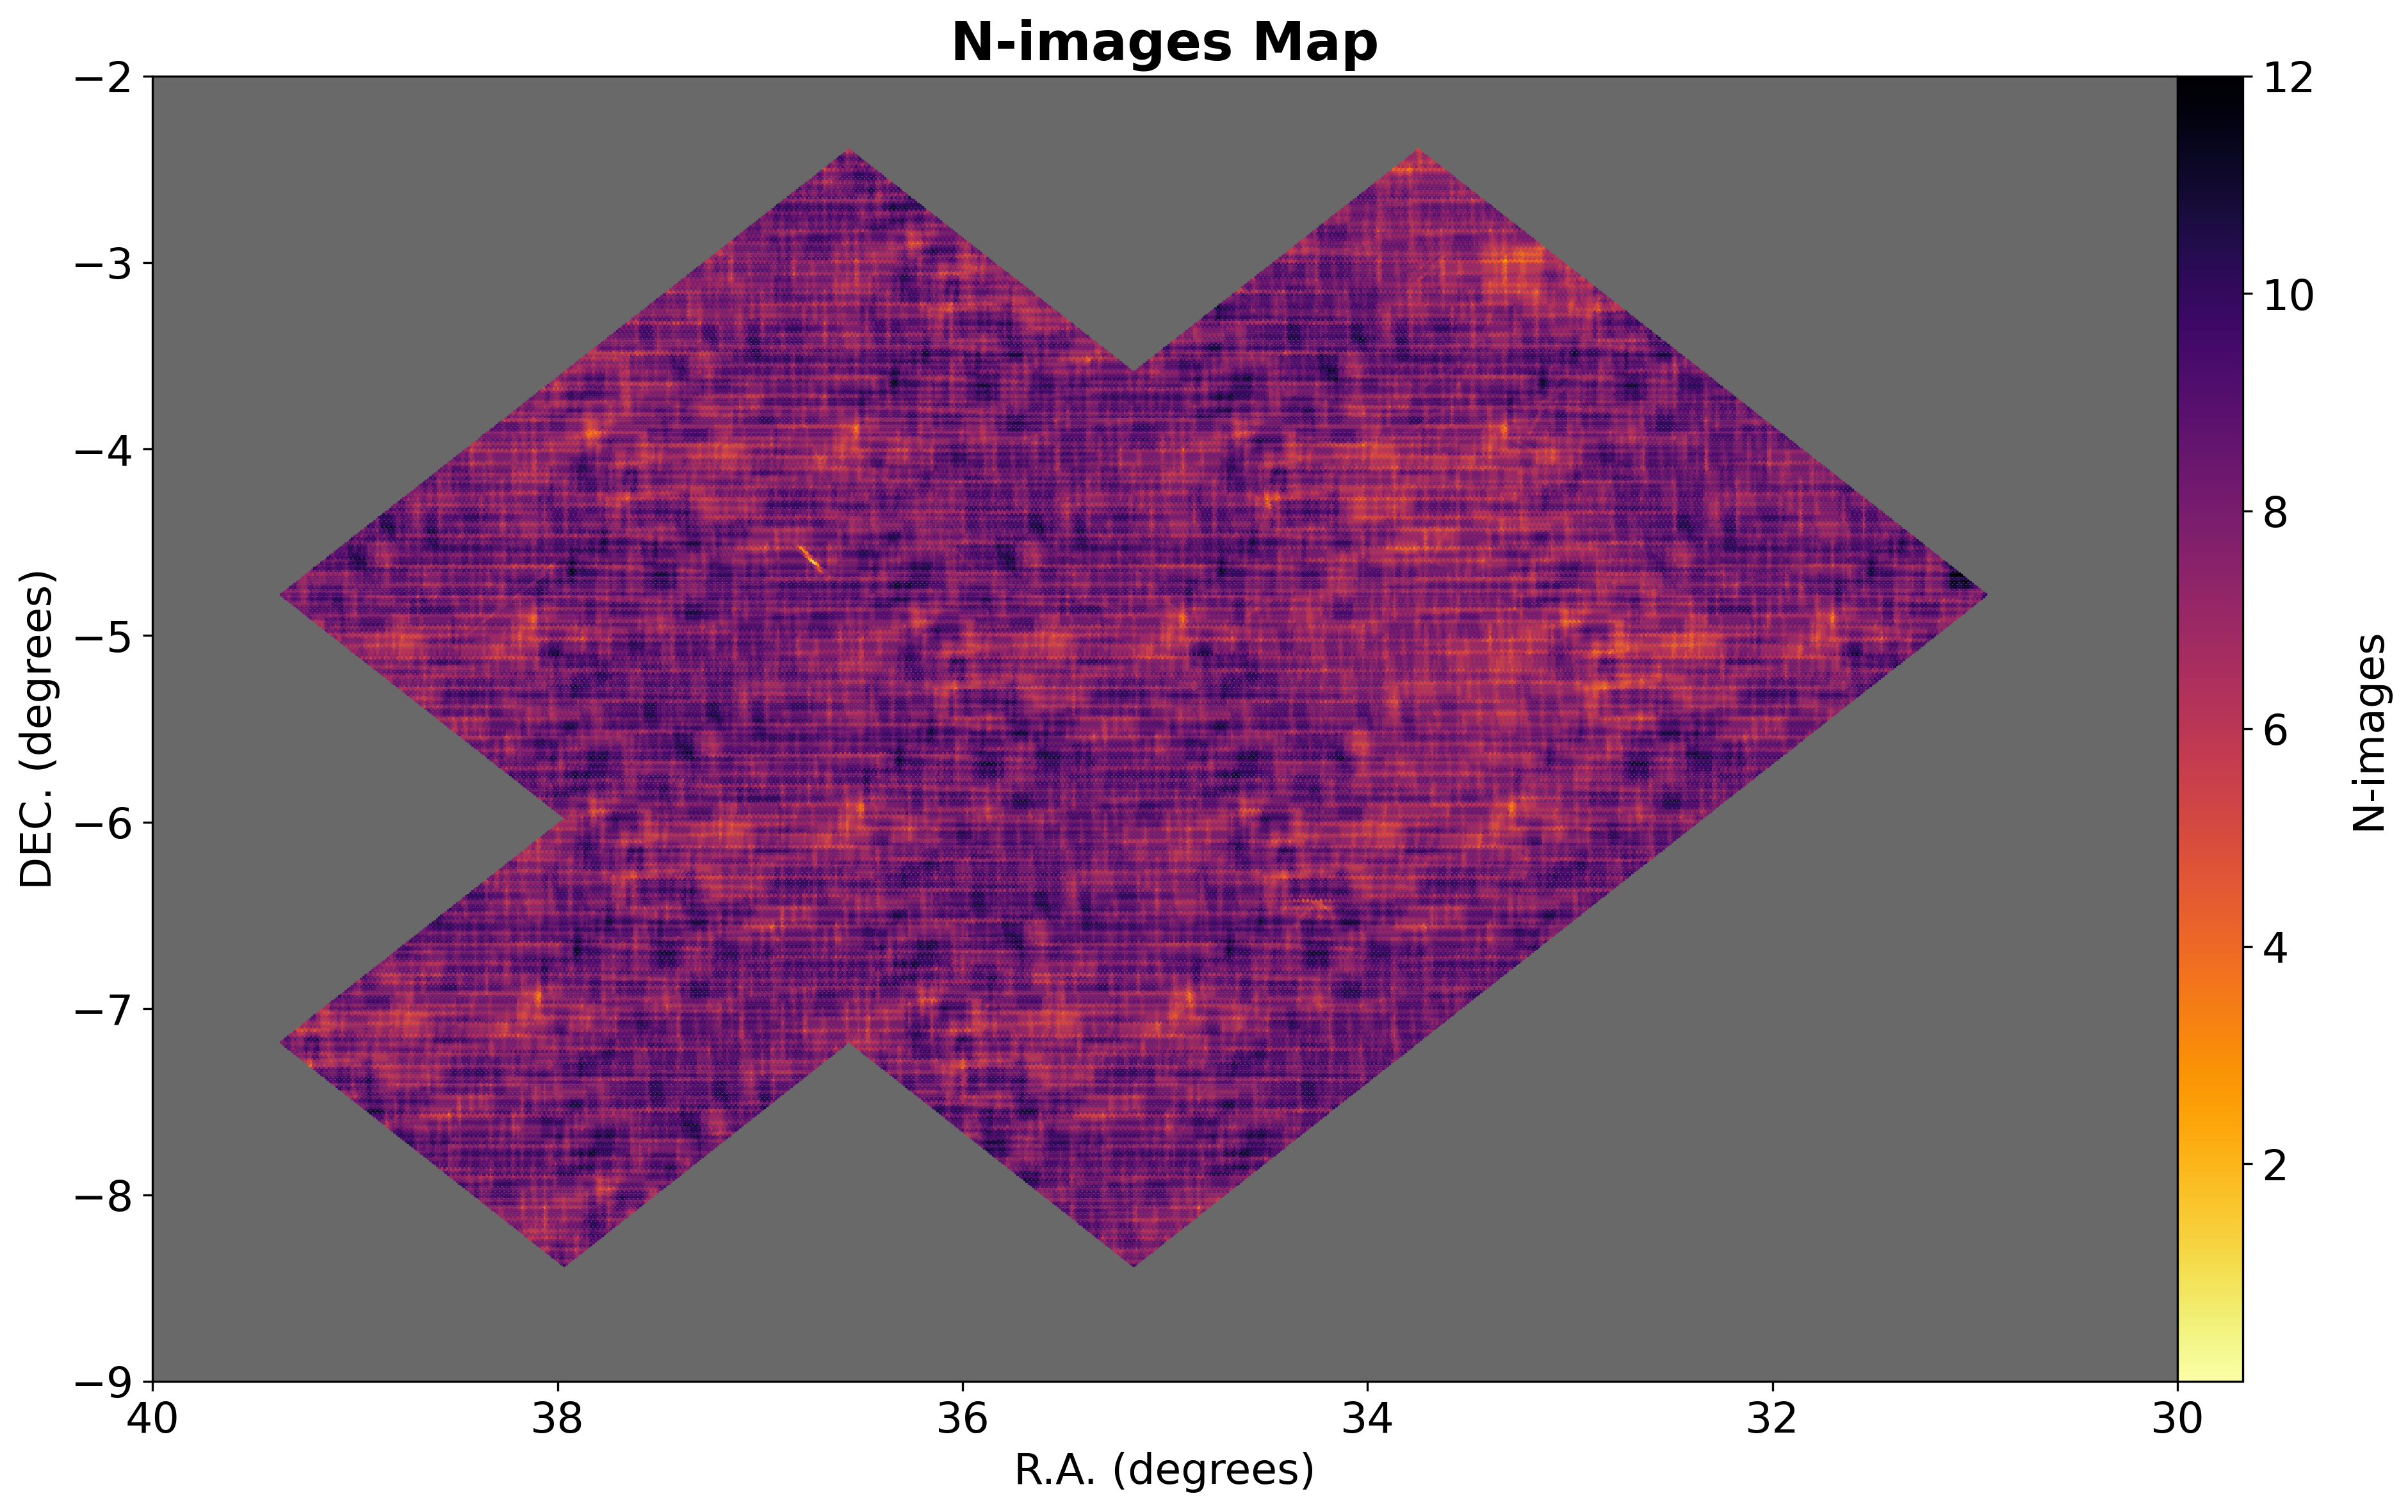

In [215]:
params = {'title':"N-images Map",
          'barlabel':"N-images",
          'vmin':0,
          'vmax':12,
          'cmap':cm.inferno_r,
          'setticks':[2,4,6,8,10,12],
          'mask': 1.0,
          'colorbar': True
         }
plot_map(n_images_table, 4096, 'cartesian', params)

### Foreground objects mask map

<Figure size 1800x1200 with 0 Axes>

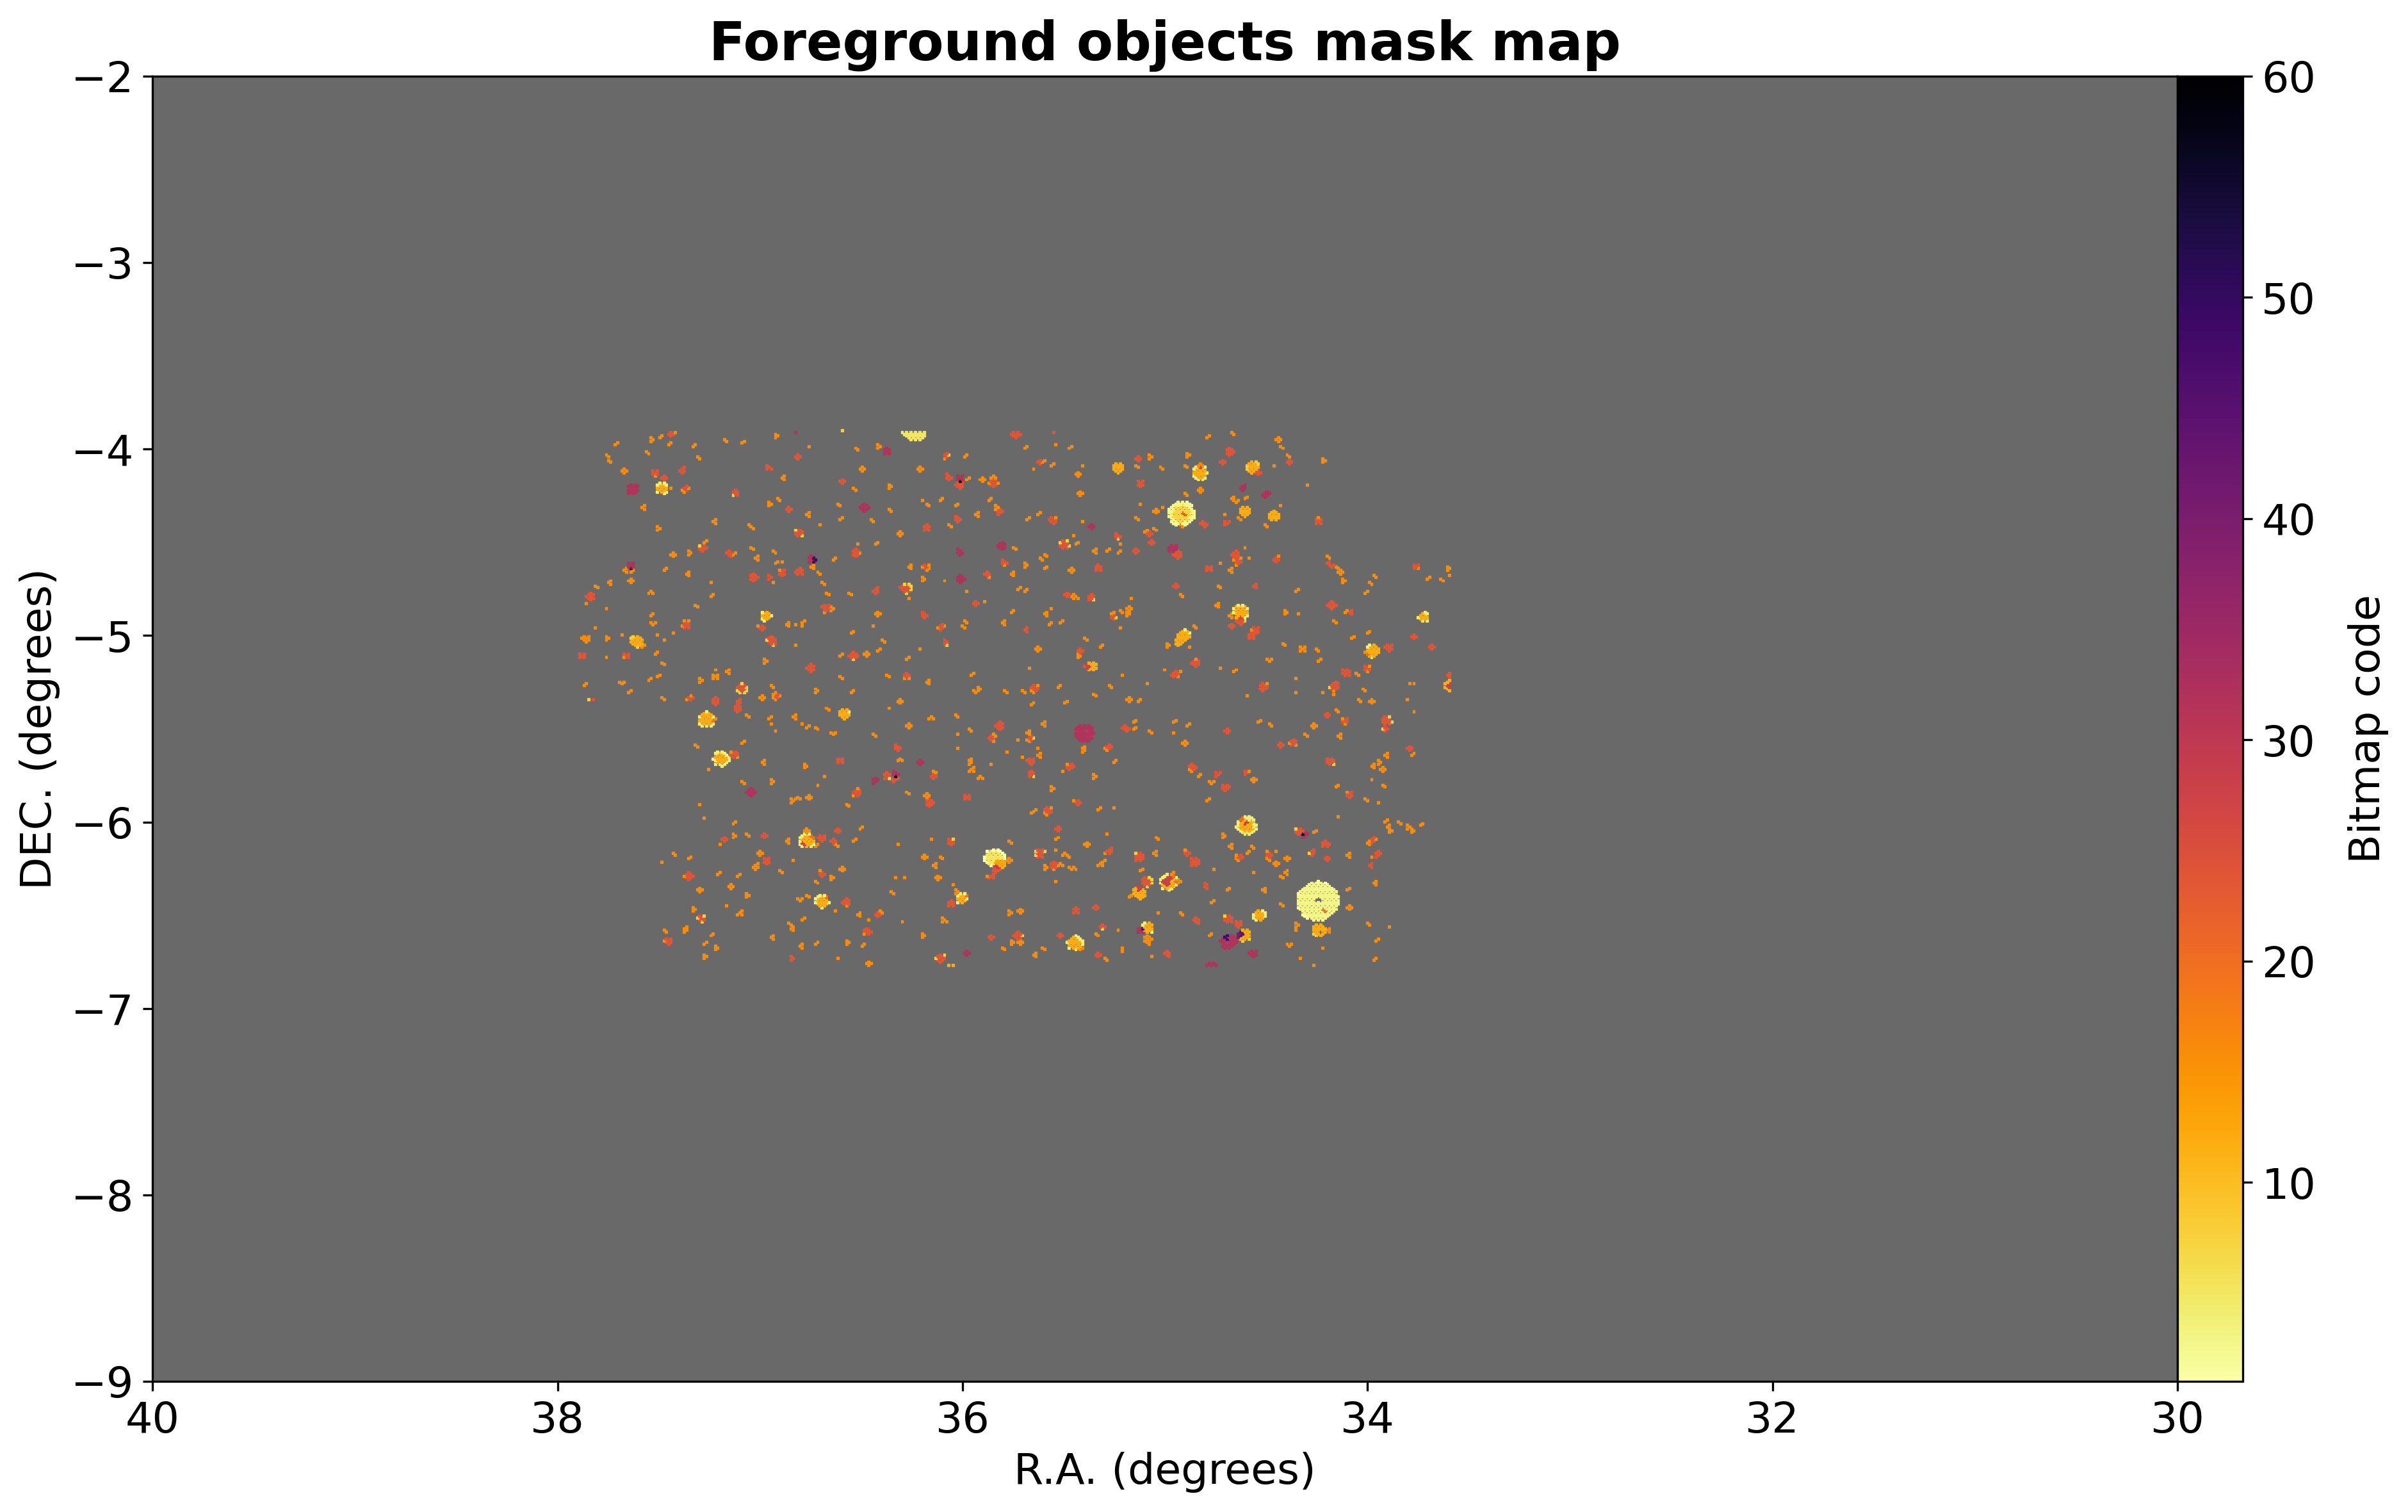

In [239]:
params = {'title':"Foreground objects mask map",
          'barlabel':"Bitmap code",
          'vmin':1,
          'vmax':60,
          'cmap':cm.inferno_r,
          'setticks':[0,10,20,30,40,50,60],
          'mask': 0,
          'colorbar': True
         }
plot_map(fore_obj_mask_table, 4096, 'cartesian', params)

### Footprint Map

<Figure size 1800x1200 with 0 Axes>

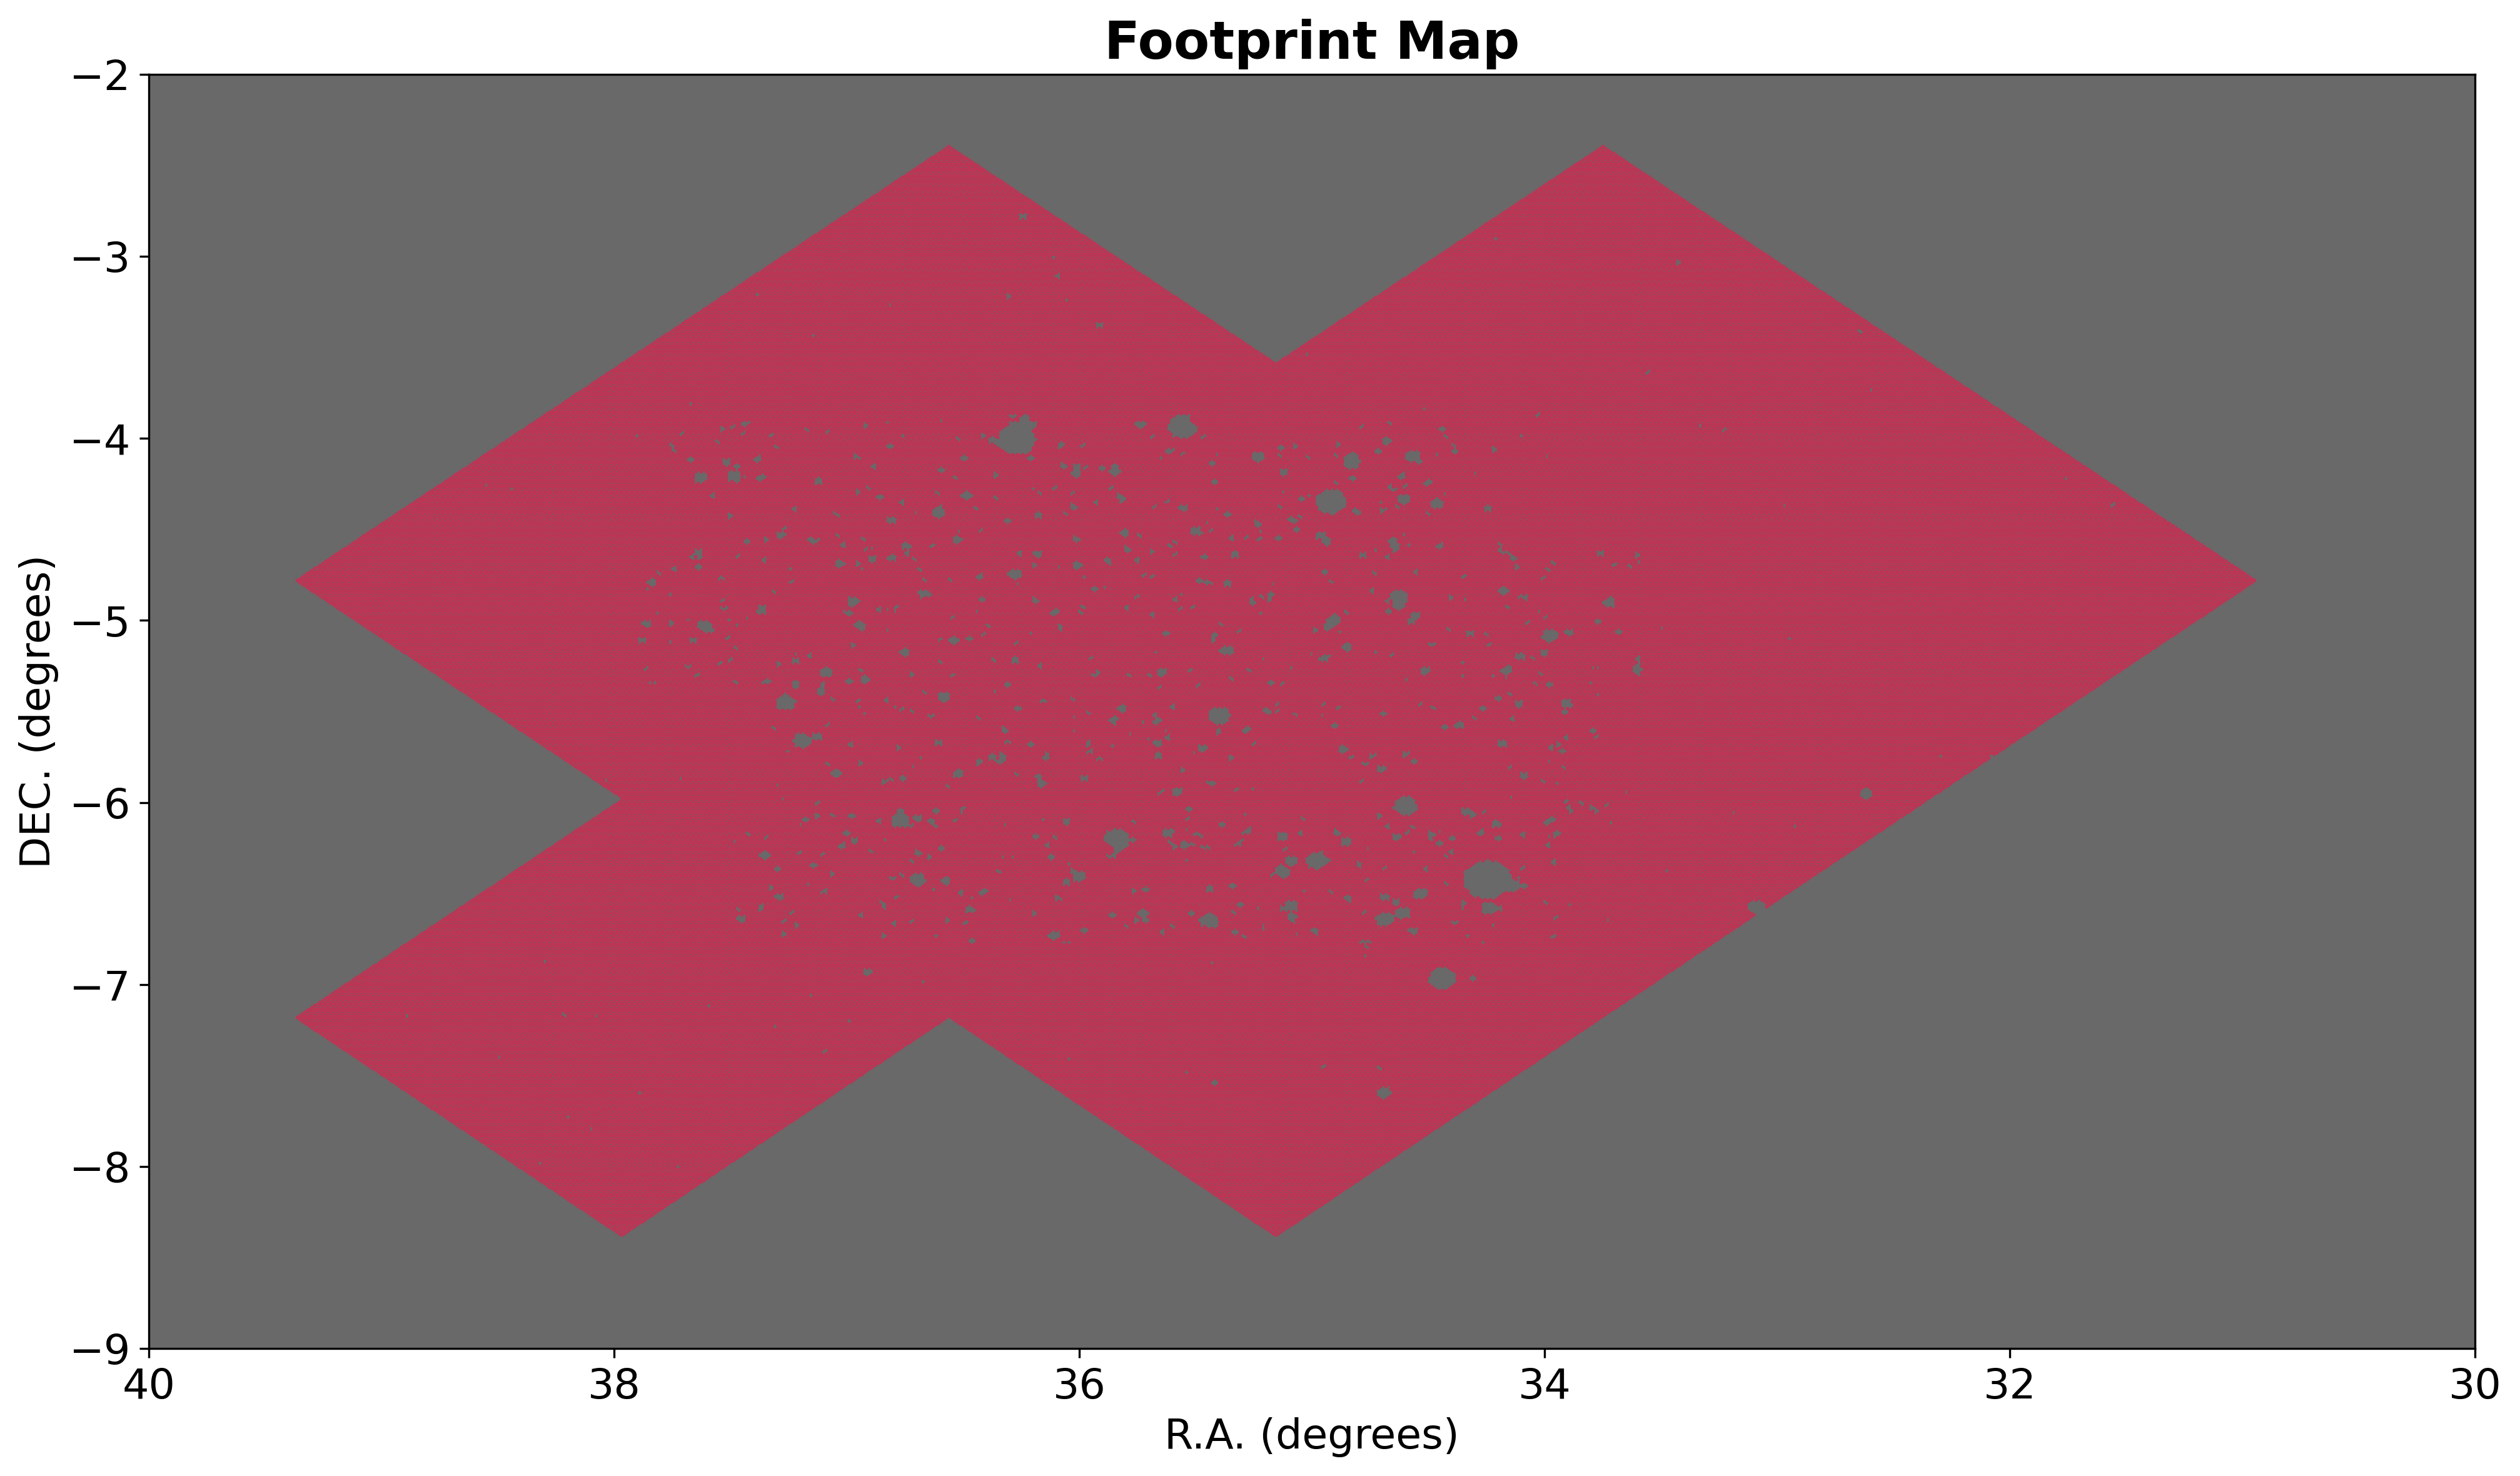

In [216]:
params = {'title':"Footprint Map",
          'barlabel':"Signal",
          'vmin':0,
          'vmax':2,
          'cmap':cm.inferno_r,
          'setticks':[0,1,2],
          'mask': 0,
          'colorbar': False
         }
plot_map(footprint_table, 4096, 'cartesian', params)

In [ ]:
'''#How To plot when given indices and signals. REMEMBER NEST = TRUE.
dumb_map = -np.inf*np.ones(npixels)
for i in np.arange(0, len(table['pixel'])):
    dumb_map[int(table['pixel'][i])] = np.array(table['signal'][i])'''